Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)


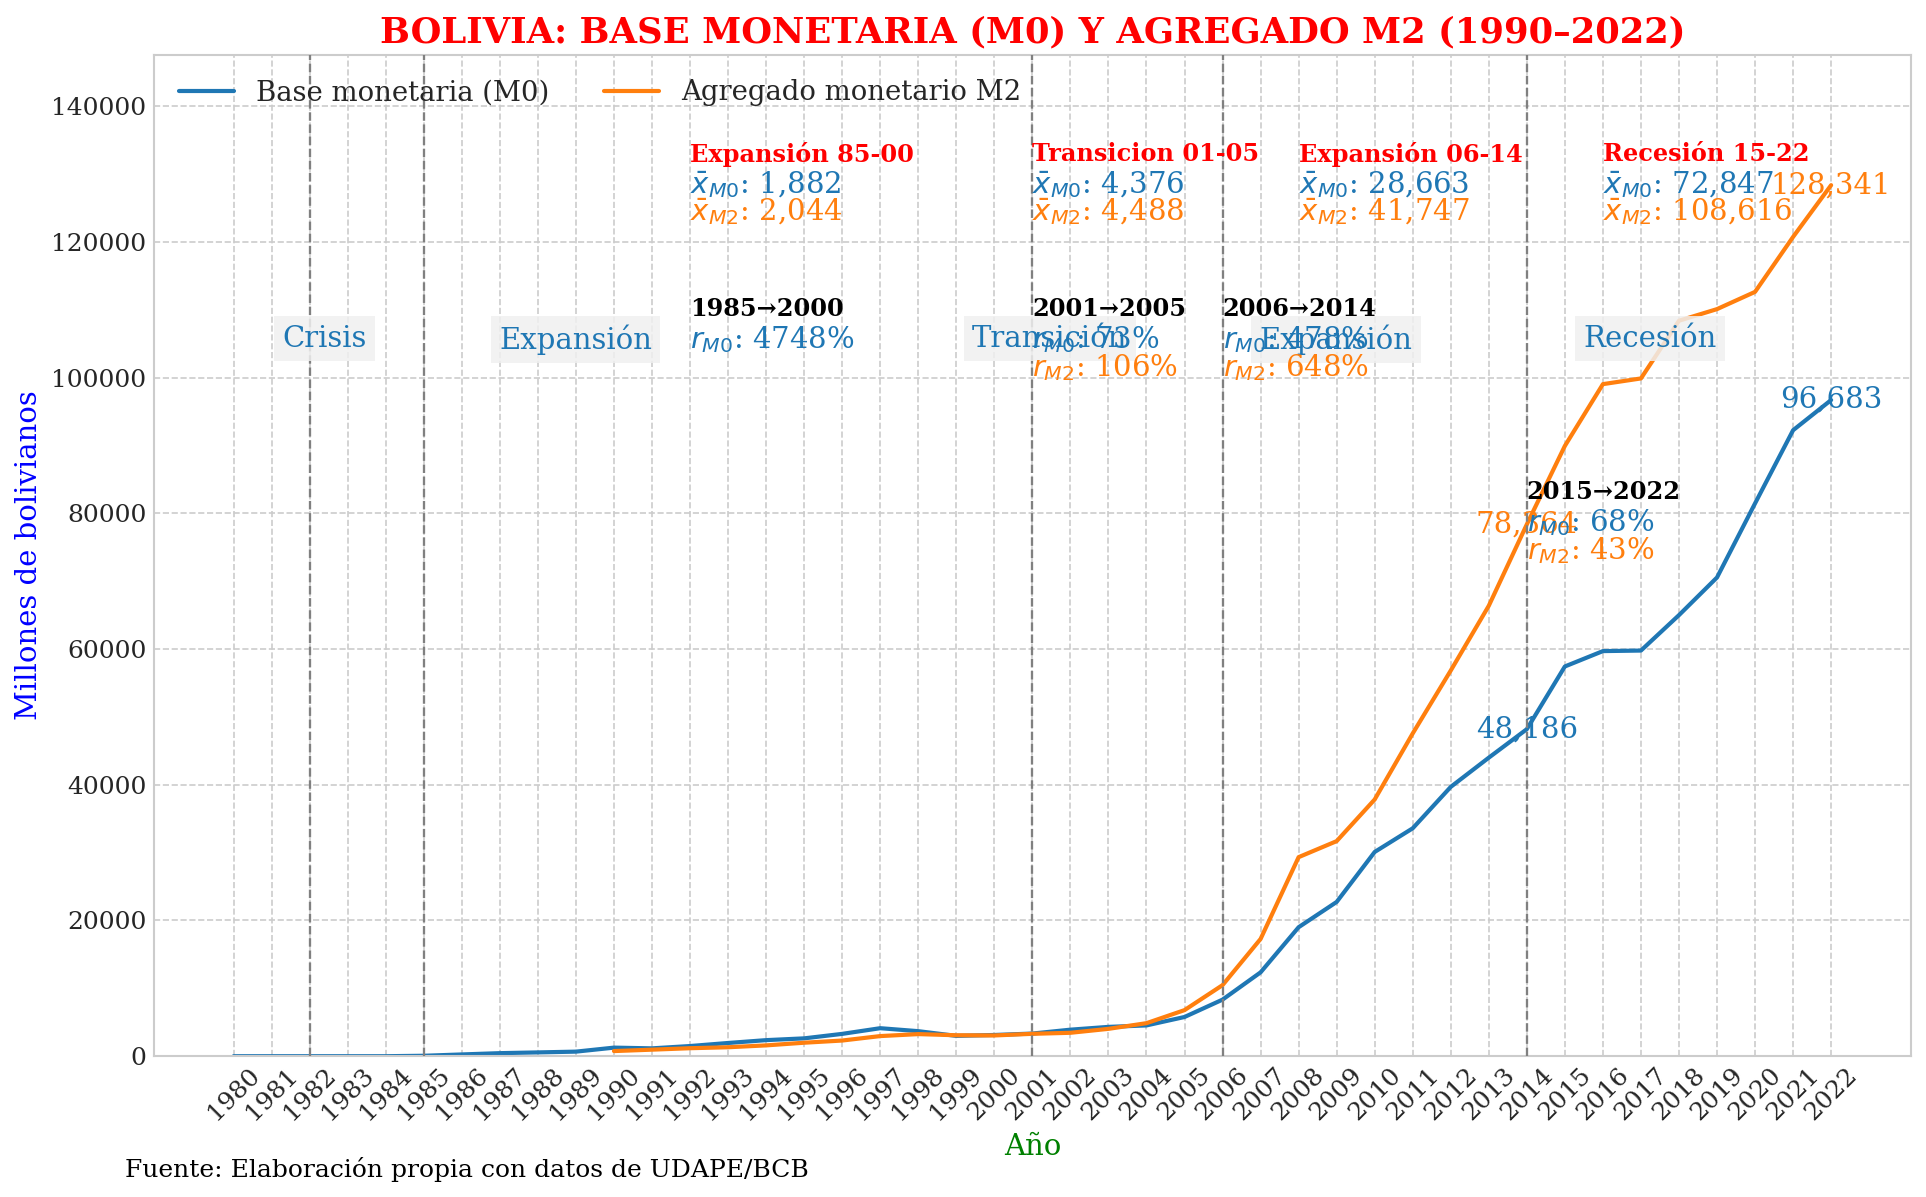

In [1]:
# ─────────────────────────────────────────────────────────────────────
# Importaciones
# ─────────────────────────────────────────────────────────────────────
import sys, os, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from func_auxiliares.config import *
from func_auxiliares.graficos_utils import *
# ─────────────────────────────────────────────────────────────────────
# Configuración general
# ─────────────────────────────────────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/monetaria"
os.makedirs(output_dir, exist_ok=True)
set_style()

# ─────────────────────────────────────────────────────────────────────
# Carga de datos
# ─────────────────────────────────────────────────────────────────────
with sqlite3.connect(str(DB_PATH)) as conn:
    df = (pd.read_sql('SELECT año, m0, m2 FROM agregados_monetarios', conn)
            .set_index('año')
            .sort_index())/ 1000 # miles → millones

# ─────────────────────────────────────────────────────────────────────
# Componentes y columnas
# ─────────────────────────────────────────────────────────────────────
componentes = [
    ('m0', 'Base monetaria (M0)'),
    ('m2', 'Agregado monetario M2'),
]
cols_componentes = [col for col, _ in componentes]

# Abreviaturas para anotaciones
abbr_map = {
    'm0': 'M0',
    'm2': 'M2',
}

# Colores (puedes reemplazar por tu paleta en config)
custom_colors = {
    'm0': '#1f77b4',
    'm2': '#ff7f0e',
}

# ─────────────────────────────────────────────────────────────────────
# Preparación (usa helpers de tu proyecto)
# ─────────────────────────────────────────────────────────────────────
# Ajustes de años a anotar y ciclos, reusando tu configuración global
annotate_years    = adjust_annot_years(df, annot_years)
CYCLES            = adjust_cycles(df, CYCLES)
cycle_stats       = {name: df.loc[period, cols_componentes].mean().to_dict()
                     for name, period in CYCLES.items()}
periodos          = adjust_periods(df, periodos_tasas)

# Offsets mínimos para apuntadores de valores (ajusta si se solapan)
annotation_offsets = {
    'm0': {1990: (0, 0), 2008: (0, 0), 2014: (0, 0), 2022: (0, 0)},
    'm2': {1990: (0, 0), 2008: (0, 0), 2014: (0, 0), 2022: (0, 0)},
}

hitos_offset = {a: 0.8 for a in hitos_v}  
hitos_text_x = {
    1952: 1.9,
    1956: 6,
    1970: 5,
    1982: 1.5,
    1985: 6,
    2001: 2.5,
    2006: 5,
    2014: 5
}

# Posiciones de las medias por ciclo (ajústalas si cambias CYCLES)
medias_offsets = {
    "Expansión 56-69":    (1962, 1),
    "Recesión 70-81":     (1975, 1),
    "Expansión 85-00":    (1992, 1),
    "Transicion 01-05":   (2001, 1),
    "Expansión 06-14":    (2008, 1),
    "Recesión 15-22":     (2016, 1),
}

# Tasas anotadas por periodo (si no deseas tasas, comenta el bloque de add_period...)
tasas_offsets = {
    "1956-1969": (1963, 0.83),
    "1970-1981": (1976, 0.83),
    "1985-2000": (1992, 0.83),
    "2001-2005": (2001, 0.83),
    "2006-2014": (2006, 0.83),
    "2015-2022": (2014, 0.63),
}

# ─────────────────────────────────────────────────────────────────────
# Gráfica
# ─────────────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df,
    componentes,
    custom_colors,
    "BOLIVIA: BASE MONETARIA (M0) Y AGREGADO M2 (1990–2022)",
    "Año",
    "Millones de bolivianos",
    source_text="Fuente: Elaboración propia con datos de UDAPE/BCB"
)

# Hitos verticales
add_hitos(ax, df.index, hitos_v, hitos_offset,
          annotate_labels=('Crisis','Recesión', 'Expansión', 'Transición'),
          vertical_labels=False,
          hitos_x_text=hitos_text_x)

# Medias por ciclo (líneas y etiquetas por ciclo)
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03
add_cycle_means_multi(
    ax, cycle_stats, medias_offsets,
    abbr_map, custom_colors,
    line_spacing
)

# Anotar valores en años clave
add_year_value_annotations(
    ax, df, annotate_years,
    cols_componentes, annotation_offsets,
    custom_colors, arrow_lw=0.6
)

# Tasas de crecimiento por periodos (opcional; usa periodos_tasas de config)
add_period_growth_annotations_multi(
    ax, df, periodos,
    cols_componentes, tasas_offsets,
    custom_colors, abbr_map
)

# Límite inferior en cero y margen superior
ax.set_ylim(0, df[cols_componentes].max().max() * 1.15)

# Guardado y despliegue
plt.savefig(os.path.join(output_dir, "m0_m2.png"), dpi=300, bbox_inches="tight")
plt.show()
